In [2]:
import rasterio
from rasterio.plot import show
import rasterio.warp
import rasterio.mask
import shapely.geometry
from affine import Affine
import warnings
import time
import os

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas
from osgeo import gdal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
year = 2014
cell_size = 5000
geodetic_epsg = 'EPSG:4326'
projected_epsg = 'EPSG:20935' 
country_code = 'ZMB' # 'TZA' # 'NGA'
taylor_data_dir = "/capstone/cropmosaiks/data"  

In [4]:
# africa = geopandas.read_file(taylor_data_dir+'/boundaries/africa_adm0.geojson')
# country = africa[africa.adm0_a3 == country_code]

# # Project country into local EPSG with units in meters
# country_prj = country.to_crs(projected_epsg)

# # Create grid of points
# xmin, ymin, xmax, ymax = country_prj.total_bounds
# xs = list(np.arange(xmin, xmax + cell_size, cell_size))
# ys = list(np.arange(ymin, ymax + cell_size, cell_size))
# def make_cell(x, y, cell_size):
#     ring = [
#         (x, y),
#         (x + cell_size, y),
#         (x + cell_size, y + cell_size),
#         (x, y + cell_size)
#     ]
#     cell = shapely.geometry.Polygon(ring).centroid
#     return cell
# cells = []
# for x in xs:
#     for y in ys:
#         cell = make_cell(x, y, cell_size)
#         cells.append(cell)

# # Put grid into a GeDataFrame and select points
# grid = geopandas.GeoDataFrame({'geometry': cells}, crs = projected_epsg)
# grid['lon'] = grid.geometry.x
# grid['lat'] = grid.geometry.y
# grid['x'] = grid.groupby(['lon']).ngroup() + 1
# grid['y'] = grid.groupby(['lat']).ngroup() + 1
# grid['includepoint'] = (grid.y + grid.x) % 2 == 0 
# grid = grid[grid.includepoint]

# # Reproject grid and subset to country again
# gdf = grid[grid.within(country_prj.unary_union)]
# gdf = gdf.to_crs(geodetic_epsg)
# gdf['lon'] = gdf.geometry.x
# gdf['lat'] = gdf.geometry.y
# gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
# gdf.shape

In [5]:
# Set params
country_code = 'ZMB'
year = 2018
geodetic_epsg = 'EPSG:4326'
# get country shape
africa = geopandas.read_file(taylor_data_dir+'/boundaries/africa_adm0.geojson')
country = africa[africa.adm0_a3 == country_code]
# world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# country = world.query(f'iso_a3 == "{country_code}"')
# Create grid of points
cell_size = .01  # Very roughly 1 km
xmin, ymin, xmax, ymax = country.total_bounds
xs = list(np.arange(xmin, xmax + cell_size, cell_size))
ys = list(np.arange(ymin, ymax + cell_size, cell_size))
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = shapely.geometry.Polygon(ring).centroid
    return cell
points = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        points.append(cell)
# Put grid into a GeDataFrame
gdf = geopandas.GeoDataFrame({'geometry': points}, crs = geodetic_epsg)
gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y
# subset to country 
gdf = gdf[gdf.within(country.unary_union)]
gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
gdf.shape

(628198, 3)

In [6]:
gdf.shape

(628198, 3)

In [7]:
# gdal.Warp(
#     destNameOrDestDS = taylor_data_dir+'/cropland_rasters/output_crop_raster.tif', 
#     srcDSOrSrcDSTab  = taylor_data_dir+'/cropland_rasters/Global_cropland_SE_2019.tif', 
#     outputBounds     = country.total_bounds,
#     cropToCutline    = True,
#     copyMetadata     = True,
#     creationOptions = ['TFW=YES', 'COMPRESS=LZW']
# )

In [8]:
a = taylor_data_dir+'/cropland_rasters/output_crop_raster.tif'

In [6]:
f = rasterio.open(a)

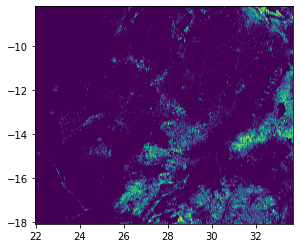

<AxesSubplot:>

In [7]:
show(f)

In [9]:
points = gdf[["lon", "lat"]].to_numpy()

In [10]:
class CustomDataset(Dataset):
    def __init__(self, points, buffer=.005):
        self.points = points
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        
        point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))

        with rasterio.Env():
            with rasterio.open(a, "r") as f:
                point_shape = shapely.geometry.shape(point_geom)
                mask_shape = point_shape.buffer(self.buffer).envelope
                mask_geom = shapely.geometry.mapping(mask_shape)
                try:
                    out_image, out_transform = rasterio.mask.mask(
                        f, [mask_geom], crop=True
                    )
                except ValueError as e:
                    if "Input shapes do not overlap raster." in str(e):
                        return None

        out_image = out_image.squeeze()
        out_image = torch.from_numpy(out_image).float()
        return out_image
# Create the dataset
dataset = CustomDataset(points)

In [11]:
img = dataset[1000]
img

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
crops = (img == 1).sum() / img.numel()
crops.item()

0.0

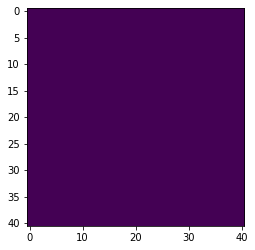

In [13]:
plt.figure()
plt.imshow(img)
plt.show()
plt.close()

In [14]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=os.cpu_count(), #*2,
    collate_fn=lambda x: x,
    pin_memory=False,
)

In [15]:
%%time
x_all = np.zeros((points.shape[0], 1), dtype=float)
tic = time.time()
i = 0
for image in dataset:

    # image = image.to(device)

    crops = (image == 1).sum() / image.numel()
    x_all[i] = crops.item()

    if i % 10000 == 0:
        print(
            f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
            + f" -- {time.time()-tic:0.2f} seconds"
        )
        tic = time.time()
    i += 1

0/628198 -- 0.00% -- 0.01 seconds
10000/628198 -- 1.59% -- 51.36 seconds
20000/628198 -- 3.18% -- 51.38 seconds
30000/628198 -- 4.78% -- 51.75 seconds
40000/628198 -- 6.37% -- 52.11 seconds
50000/628198 -- 7.96% -- 52.40 seconds
60000/628198 -- 9.55% -- 52.90 seconds
70000/628198 -- 11.14% -- 52.82 seconds
80000/628198 -- 12.73% -- 52.97 seconds
90000/628198 -- 14.33% -- 52.80 seconds
100000/628198 -- 15.92% -- 52.81 seconds
110000/628198 -- 17.51% -- 52.82 seconds
120000/628198 -- 19.10% -- 53.21 seconds
130000/628198 -- 20.69% -- 53.01 seconds
140000/628198 -- 22.29% -- 52.88 seconds
150000/628198 -- 23.88% -- 52.87 seconds
160000/628198 -- 25.47% -- 52.80 seconds
170000/628198 -- 27.06% -- 52.98 seconds
180000/628198 -- 28.65% -- 52.90 seconds
190000/628198 -- 30.25% -- 52.73 seconds
200000/628198 -- 31.84% -- 52.45 seconds
210000/628198 -- 33.43% -- 52.43 seconds
220000/628198 -- 35.02% -- 52.36 seconds
230000/628198 -- 36.61% -- 52.44 seconds
240000/628198 -- 38.20% -- 52.32 secon

In [16]:
crops = pd.DataFrame({'crop_perc': x_all.squeeze()})
crops[["lon", "lat"]] = points.tolist()

In [17]:
# Save the crop_weights to a feather file
# file_name = f'{taylor_data_dir}/weights/{country_code}_crop_weights_{len(points)/1000:0.0f}k-points.feather'
# file_name = f'{taylor_data_dir}/weights/{country_code}_crop_weights_{len(points)/1000:0.0f}k-points.feather'
# print("Saving file as:", file_name)
# crops.to_feather(file_name)
# print("Save finished!")

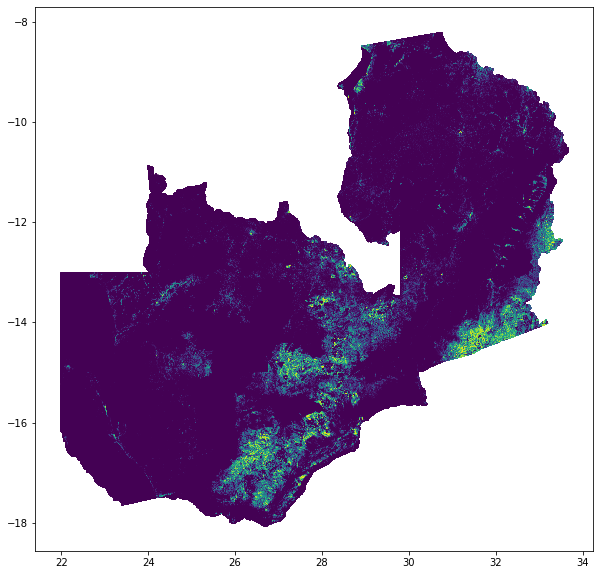

In [18]:
plt.figure(figsize = (10,10))
plt.scatter(
    crops.lon, 
    crops.lat, 
    c=crops.crop_perc, 
    s=.25,
    marker = ','
)

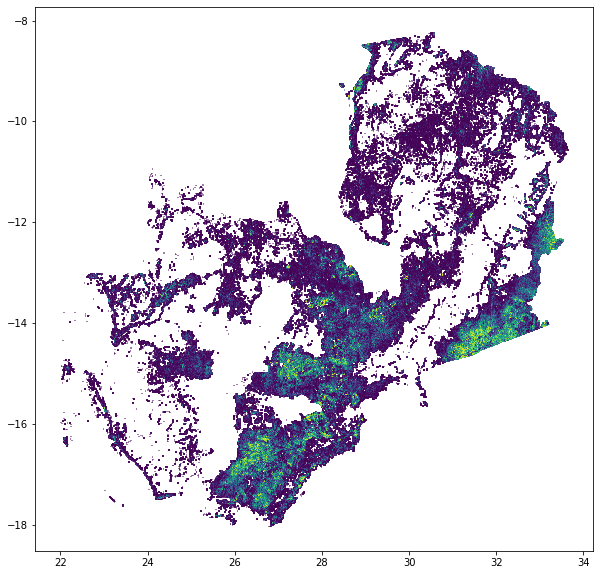

In [19]:
crops_2 = crops.replace(0, np.nan).dropna().reset_index(drop = True)
plt.figure(figsize = (10,10))
plt.scatter(
    crops_2.lon, 
    crops_2.lat, 
    c=crops_2.crop_perc, 
    s=.25,
    marker = ','
)


In [20]:
crops_2

,crop_perc,lon,lat
0,0.017252,22.004878,-15.964232
1,0.010113,22.014878,-14.854232
2,0.002974,22.014878,-14.844232
3,0.005354,22.014878,-14.294232
4,0.005354,22.024878,-15.984232
...,...,...,...
196863,0.004164,33.624878,-10.544232
196864,0.005354,33.624878,-10.534232
196865,0.004759,33.624878,-10.504232
196866,0.004164,33.634878,-10.554232


In [21]:
crops_3 = crops_2.sample(frac = .1).reset_index(drop = True)
crops_3

,crop_perc,lon,lat
0,0.008923,31.394878,-8.744232
1,0.117192,28.634878,-12.934232
2,0.207615,28.394878,-16.394232
3,0.046996,28.074878,-15.184232
4,0.686496,28.684878,-14.424232
...,...,...,...
19682,0.045806,26.864878,-15.194232
19683,0.001190,28.714878,-11.704232
19684,0.001190,31.014878,-11.404232
19685,0.038073,30.414878,-9.944232


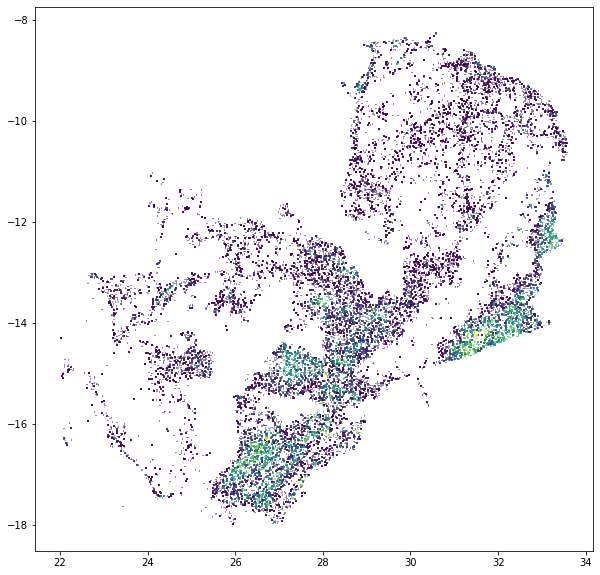

In [22]:
plt.figure(figsize = (10,10))
plt.scatter(
    crops_3.lon, 
    crops_3.lat, 
    c=crops_3.crop_perc, 
    s=.3,
    marker = ','
)

In [25]:
file_name = f'{taylor_data_dir}/weights/{country_code}_crop_weights_{len(points)/1000:0.0f}k-points.feather'
file_name

'/capstone/cropmosaiks/data/weights/ZMB_crop_weights_628k-points.feather'

In [26]:
print("Saving file as:", file_name)
crops.to_feather(file_name)
print("Save finished!")

Saving file as: /capstone/cropmosaiks/data/weights/ZMB_crop_weights_628k-points.feather
Save finished!
